<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-разделу" data-toc-modified-id="Вывод-по-разделу-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод по разделу</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Feature-Extraction" data-toc-modified-id="Feature-Extraction-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Feature Extraction</a></span></li><li><span><a href="#Подготовка-выборок" data-toc-modified-id="Подготовка-выборок-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подготовка выборок</a></span></li><li><span><a href="#Функция-для-кросс-валидации" data-toc-modified-id="Функция-для-кросс-валидации-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Функция для кросс-валидации</a></span></li><li><span><a href="#Подбор-базовой-модели" data-toc-modified-id="Подбор-базовой-модели-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Подбор базовой модели</a></span></li><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span><ul class="toc-item"><li><span><a href="#Регрессия" data-toc-modified-id="Регрессия-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>Регрессия</a></span></li><li><span><a href="#Random-Forest-Regressor" data-toc-modified-id="Random-Forest-Regressor-3.5.2"><span class="toc-item-num">3.5.2&nbsp;&nbsp;</span>Random Forest Regressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.5.3"><span class="toc-item-num">3.5.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#VotingRegressor" data-toc-modified-id="VotingRegressor-3.5.4"><span class="toc-item-num">3.5.4&nbsp;&nbsp;</span>VotingRegressor</a></span></li><li><span><a href="#DummyRegressor-(средняя)" data-toc-modified-id="DummyRegressor-(средняя)-3.5.5"><span class="toc-item-num">3.5.5&nbsp;&nbsp;</span>DummyRegressor (средняя)</a></span></li></ul></li><li><span><a href="#Вывод-по-разделу" data-toc-modified-id="Вывод-по-разделу-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Вывод по разделу</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Постройте модель для такого предсказания.

## Подготовка

In [1]:
# загрузим необходимые библиотеки
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)
%matplotlib inline

In [2]:
# загрузим данные
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
# проверим, требуется ли сортировка по индексу
data.index.is_monotonic

True

Не требуется

In [4]:
# посмотрим общую информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Нам дана информация о заказах такси в период с 1 марта по 31 августа 2018 года. Всего 26496 записей.

In [5]:
# посмотрим на данные глазами
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


Нам дана информация по заказам за 10-минутные интервалы времени.

In [6]:
# посмотрим статистики данных
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Минимальное число заказов за 10-минутный интервал - 0, максимальное - 119.

Ресемплируем данные по одному часу.

In [7]:
data = data.resample('1H').sum()

In [8]:
# проверяем
data.head(2)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85


Все ок.

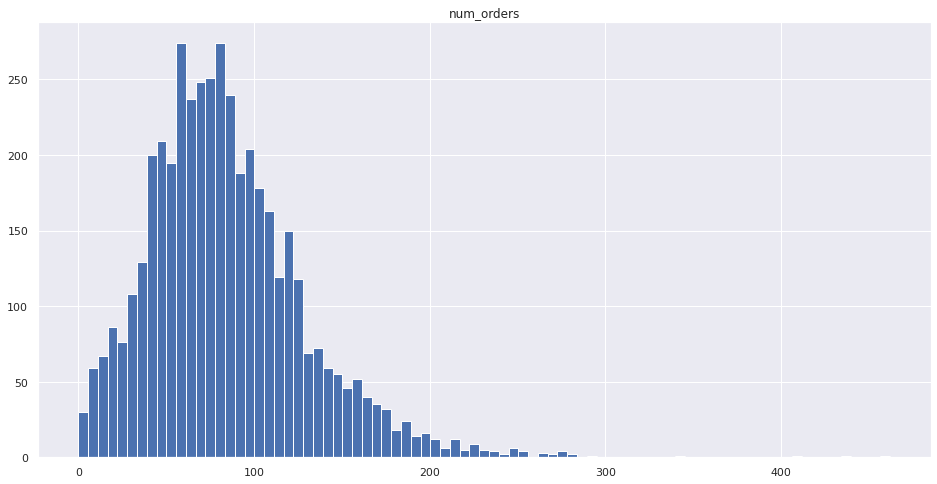

In [9]:
data.hist(bins=data.num_orders.nunique() // 3, figsize=(16,8));

Наблюдаем классическое распределение Пуассона. Можем заметить, что число заказов выше 200 - достаточно редкое явление, а выше 300 - очень редкое исключение.

Добавив в данные средние и стандартное отклонение на скользящем окне за 24 часа для последующего анализа временного ряда.

In [10]:
data['rolling_mean'] = data.num_orders.rolling(24).mean()
data['rolling_std'] = data.num_orders.rolling(24).std()

Мы провели ресемплирование данных и подготовили их для анализа.

## Анализ

Проанализируем временной ряд. Сначала оценим его визуально

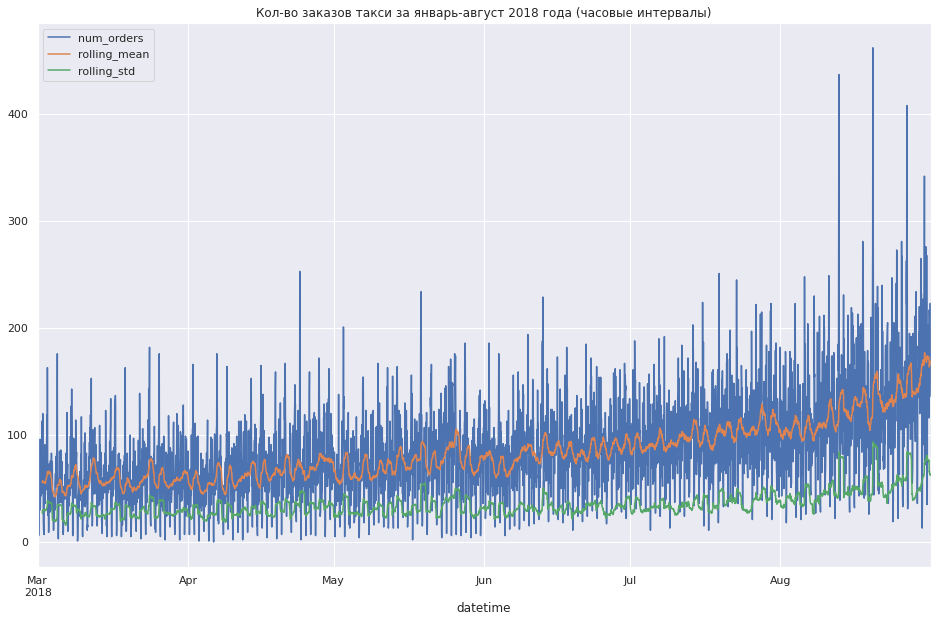

In [11]:
# посмотрим на временной ряд
figsize = (16, 10)
data.plot(figsize=figsize).\
                    set_title('Кол-во заказов такси за январь-август 2018 года (часовые интервалы)');

Наблюдаем тренд на повышение кол-ва заказов во времени (пиковые значения, которые мы отметили выше, также приходятся на конец периода - август).

Попробуем оценить сезонность и особенности выходных дней. 

Посмотрим на двухдневный интервал (будние дни).

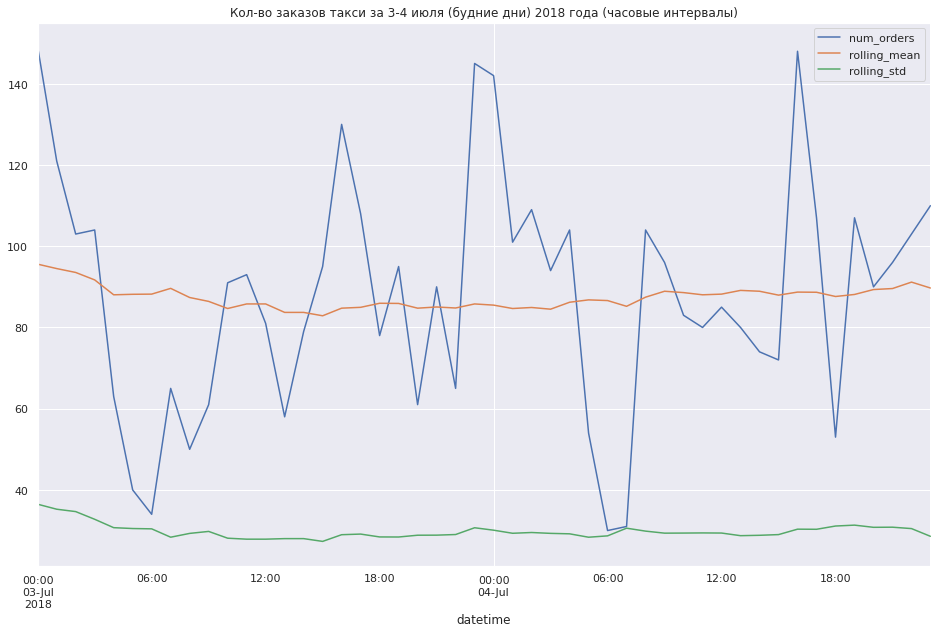

In [12]:
data['2018-07-03':'2018-07-04'].plot(figsize=(16, 10)).\
                set_title('Кол-во заказов такси за 3-4 июля (будние дни) 2018 года (часовые интервалы)');

Отчетливо прослеживается внутридневная сезонность - два пика заказов, приходящихся на ночное время около полуночи и на вечернее время около 17-18 часов (окончание рабочего дня), а также провалы заказов ближе к утру (около 5-6 утра).

Посмотрим на особенность выходных дней (с пятницы до понедельника).

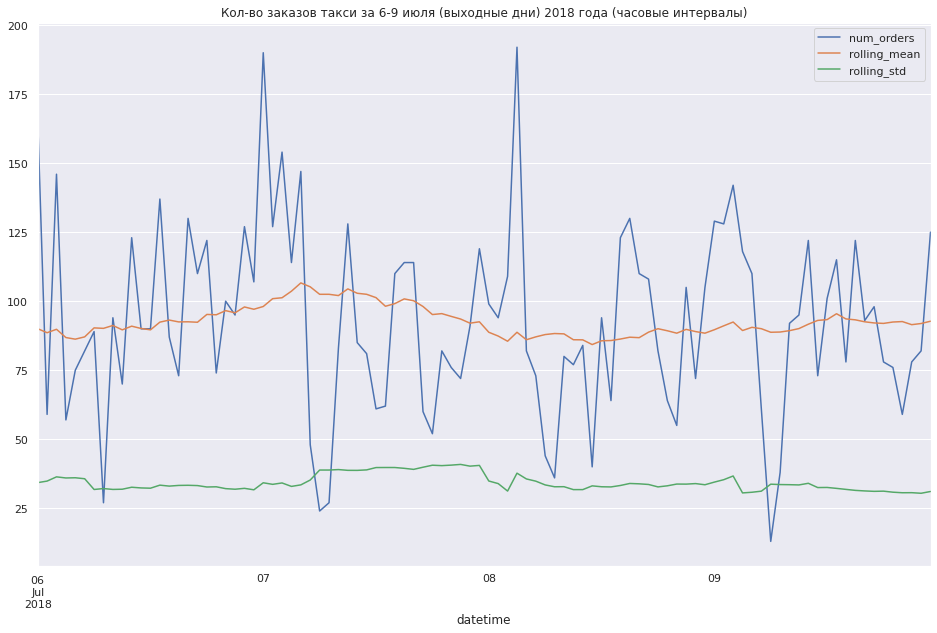

In [13]:
data['2018-07-06':'2018-07-09'].plot(figsize=(16, 10)).\
                set_title('Кол-во заказов такси за 6-9 июля (выходные дни) 2018 года (часовые интервалы)');

Выходные дни отличаются чуть более высокими ночными пиками в ночь с пятницы на субботу и с субботы на воскресенье (клиенты развлекаются), воскресенье в целом похоже на обычный будний день.

Посмотрим на среднее количество заказов по дням недели.

In [14]:
data.groupby(data.index.day_name())['num_orders'].mean().sort_values(ascending=False)

datetime
Friday       91.140432
Monday       90.246795
Thursday     85.660494
Saturday     83.847756
Wednesday    83.754808
Sunday       78.991987
Tuesday      77.011218
Name: num_orders, dtype: float64

Наибольшее число заказов приходится на пятницу и понедельник, наименьшее - на вторник и воскресенье. Таким образом, можно наблюдать о сезонности по дням недели.

Посмотрим на среднее число заказов по часам.

In [15]:
data.groupby(data.index.hour)['num_orders'].mean().sort_values(ascending=False)

datetime
0     144.402174
16    114.146739
2     113.070652
23    109.766304
1     104.364130
3     102.021739
22     98.500000
21     95.211957
10     93.119565
17     92.722826
9      88.831522
15     87.945652
4      86.907609
11     82.489130
20     81.858696
19     77.336957
14     75.163043
8      73.048913
13     71.173913
18     69.358696
12     67.630435
5      42.630435
7      29.271739
6      25.173913
Name: num_orders, dtype: float64

Час-пиком можно считать полночь, временем непопулярных заказов - с 5 до 7 утра.

___
Посмотрим на графики тренда и сезонности на всех данных

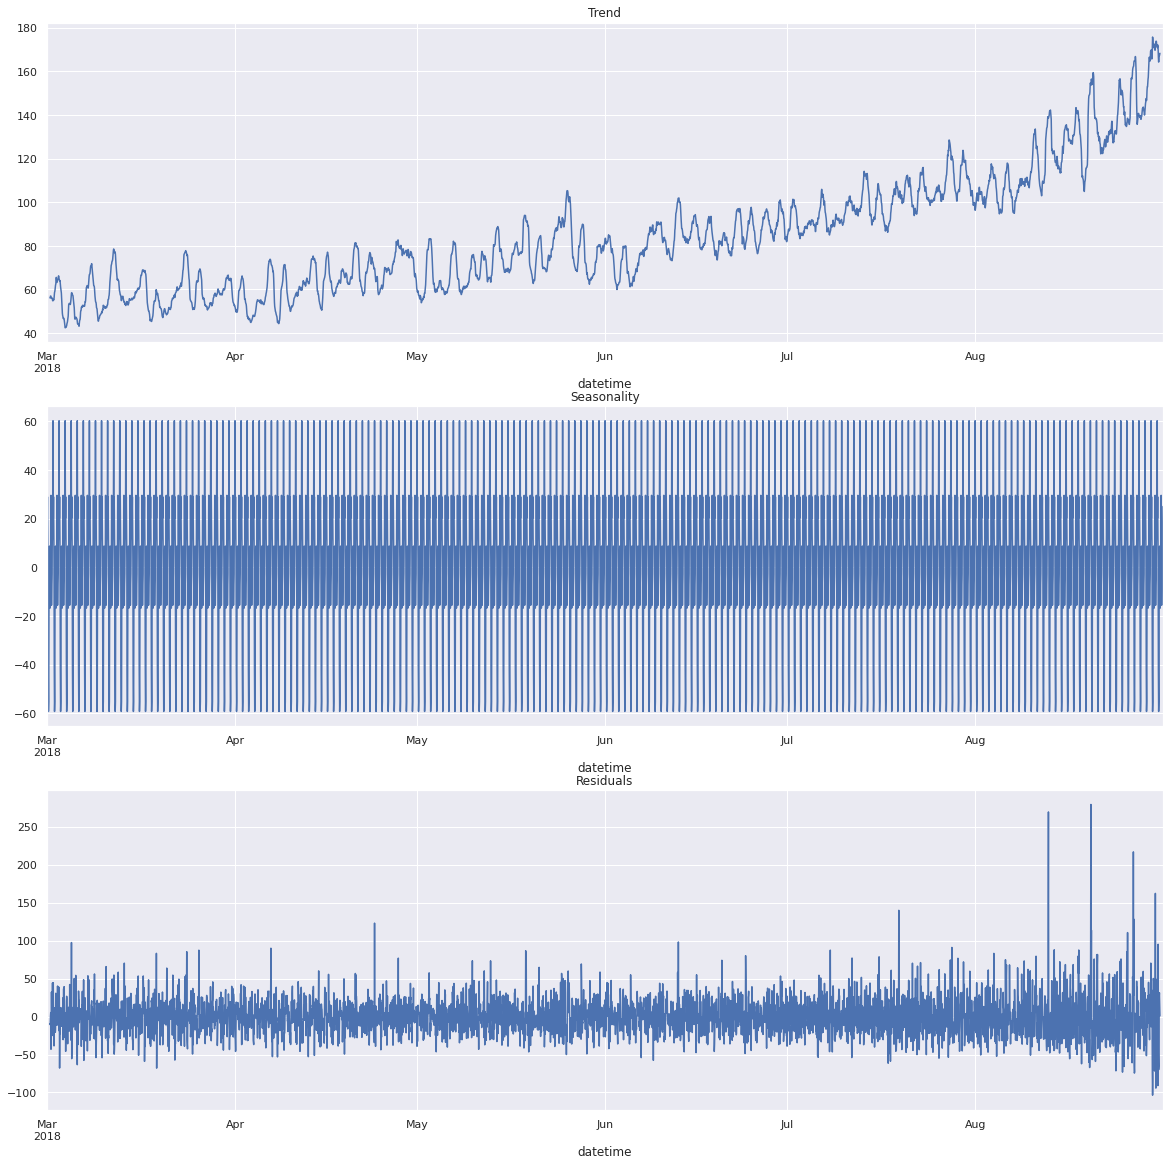

In [16]:
decomposed = seasonal_decompose(data['num_orders'])
fig,ax = plt.subplots(3,1,figsize = (20,20))

decomposed.trend.plot(ax=ax[0],title = 'Trend')
decomposed.seasonal.plot(ax=ax[1],title = 'Seasonality')
decomposed.resid.plot(ax=ax[2],title = 'Residuals');

Тренд определяется достаточно явно, посмотрим на сезонность поближе (первую полную неделю июля - со 2 по 8 число).

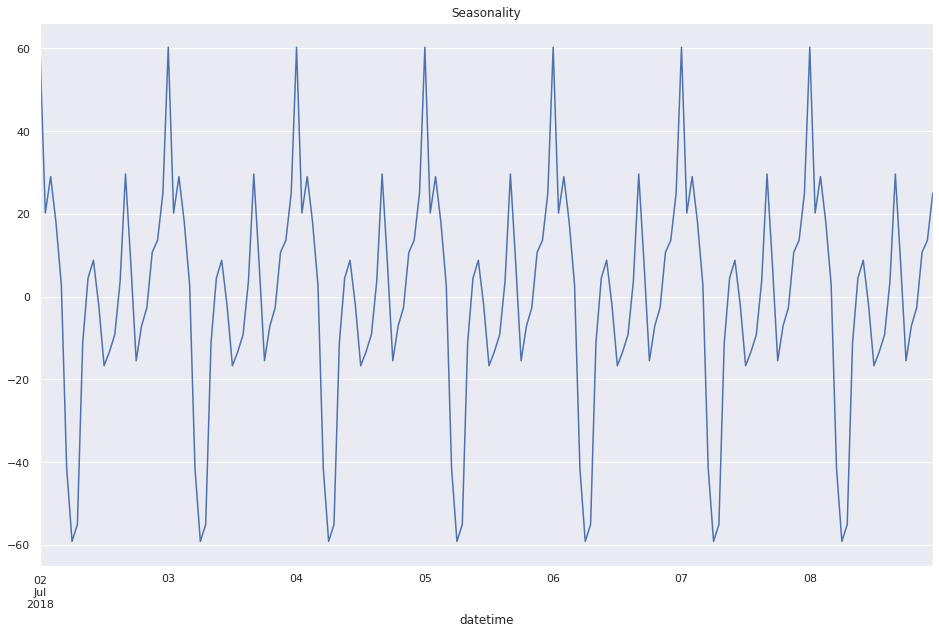

In [17]:
decomposed.seasonal['2018-07-02':'2018-07-08'].plot(figsize=figsize, title = 'Seasonality');

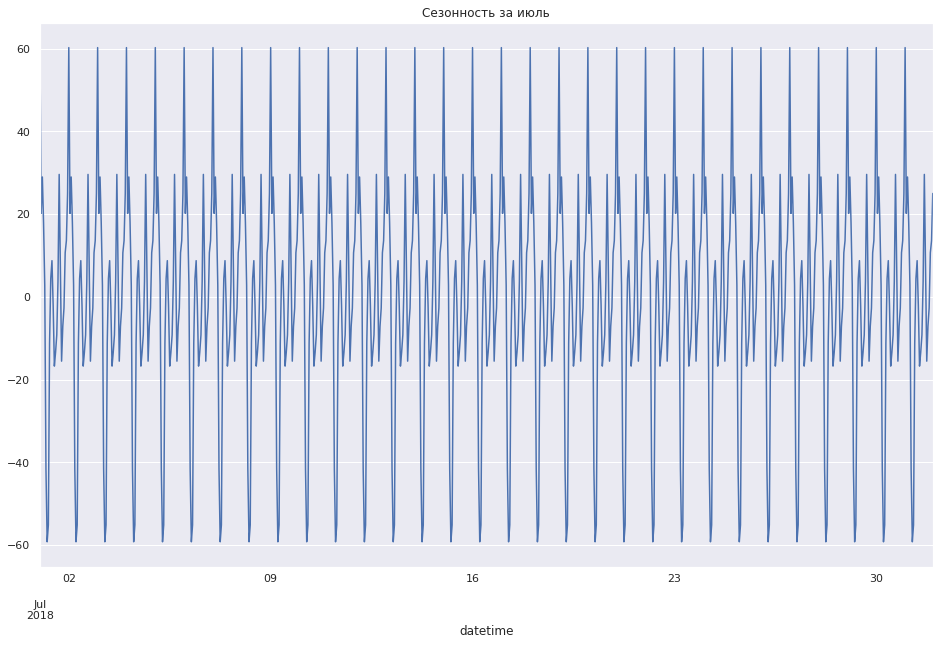

In [18]:
decomposed.seasonal['2018-07-01':'2018-07-31'].plot(figsize=figsize, title = 'Сезонность за июль');

Как и было отмечено, у нас имеется ярко выраженная внутридневная сезонность.

Согласно исследованию, можно предположить, что ряд не является стационарным (средние значения возрастают со временем). Проверим это с помощью теста Дики-Фуллера на уровне значимости 0.05.
___
Нулевую гипотезу формулируем так:

$H_0$ - исследуемый ряд не является стационарным (существует единичный корень).

Альтернативную формулируем так:

$H_1$ - исследуемый ряд стационарен (единичного корня нет).

In [19]:
# тест с константой и линейным трендом
df_test = adfuller(data['num_orders'], regression='ctt')
alpha = 0.05

print(f'p-value: {df_test[1]}')
if df_test[1] < alpha:
    print('Ряд стационарен')
else:
    print('Ряд не стационарен')

p-value: 4.0549397892403547e-17
Ряд стационарен


В соответствии с результатом теста, нулевая гипотеза отвергнута. Исследуемый ряд стационарен.

### Вывод по разделу

В результате анализа временного ряда мы обнаружили наличие тренда на повышение заказов, а также внутридневную сезонность. Дополнительно мы определили часы пик и непопулярное время заказов, а также дни недели с максимальным и минимальным числом заказов. Полученная информация позволит нам сформировать признаки для построения моделей.

С помощью теста Дики-Фуллера мы определили, что исследуемый ряд является стационарным. 

## Обучение

### Feature Extraction

Подготовим функцию для генерации фичей из наших данных. Логически кажется закономерным, чтобы на заказ такси влияли час, день недели и месяц, признак выходного дня (по хорошему нужно учитывать еще праздничные дни, но у нас нет информации о стране - источнике данных), признак час-пика (полночь), признак непопулярного времени (утро 5-7 утра), а также скользящее среднее и лаг (используем 24-часовые интервалы). Учитывая, что год в данных всего один, а номер дня месяца вряд ли имеет какое-либо значение, их мы добавлять в признаки не будем.

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    # добавляем час
    data['hour'] = data.index.hour
    # добавляем месяц
    data['month'] = data.index.month
    # добавляем день недели
    data['dayofweek'] = data.index.dayofweek
    # добавляем признак выходного дня
    data['is_weekend'] = data.dayofweek.isin([5, 6])*1
    # добавляем флаги популярного и непопулярного времени заказа
    data['is_popular_time'] = data['hour'].isin([0])*1
    data['is_not_popular_time'] = data['hour'].isin([5,6,7])*1
    # добавляем лаг
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
        
    # добавляем скользящую среднюю
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    # удаляем из данных объекты с пропусками
    data.dropna(inplace=True)

In [21]:
make_features(data, 24, 24)

Удалим лишний признак (rolling_std).

In [22]:
data = data.drop(columns=['rolling_std'])

In [23]:
data.head(3)

,num_orders,rolling_mean,hour,month,dayofweek,is_weekend,is_popular_time,is_not_popular_time,lag_1,lag_2,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,56.833333,0,3,4,0,1,0,58.0,113.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 01:00:00,120,55.416667,1,3,4,0,0,0,90.0,58.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 02:00:00,75,56.875000,2,3,4,0,0,0,120.0,90.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0


Данные добавлены.

### Подготовка выборок

Разобьем датасет на тренировочную и тестовую выборки.

In [24]:
(X_train, 
 X_test, 
 y_train, 
 y_test) = train_test_split(data.drop(columns=['num_orders']), 
                            data['num_orders'], 
                            test_size=0.1,
                            shuffle=False, 
                            random_state=22)

In [25]:
# проверяем
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3952, 31), (440, 31), (3952,), (440,))

Все корректно

### Функция для кросс-валидации

Подготовим функцию для кросс-валидации временного ряда (реализуем картинку ниже):

![jupyter](https://www.pvsm.ru/images/2017/04/24/otkrytyi-kurs-mashinnogo-obucheniya-tema-9-analiz-vremennyh-ryadov-s-pomoshyu-Python-31.png)

In [26]:
def time_series_cv_score(X, y, estimator, n_folds=5, silent=False):
    if not silent:
        print(f'Кросс-валидация на {n_folds} фолдах. Размер выборки: {len(X)}')
        print(100 * '_')
    # вектор ошибки
    errors = []

    values = y.values

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=n_folds) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(X, y):
        estimator.fit(X.iloc[train], values[train])
        predictions = estimator.predict(X.iloc[test])
        y_test = values[test]
        
        # Считаем RMSE
        error = mean_squared_error(predictions, y_test, squared=False)
        if not silent:
            print(f'Размер тренировочной выборки: {len(train)}, размер тестовой: {len(test)}')
            print(f'RMSE на разбиении: {error}')
            print(100 * '_')
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

Тестируем функцию

In [27]:
%%time
time_series_cv_score(X_train, y_train, LinearRegression())

Кросс-валидация на 5 фолдах. Размер выборки: 3952
____________________________________________________________________________________________________
Размер тренировочной выборки: 662, размер тестовой: 658
RMSE на разбиении: 22.57082254861063
____________________________________________________________________________________________________
Размер тренировочной выборки: 1320, размер тестовой: 658
RMSE на разбиении: 22.701054486076497
____________________________________________________________________________________________________
Размер тренировочной выборки: 1978, размер тестовой: 658
RMSE на разбиении: 23.411870697647128
____________________________________________________________________________________________________
Размер тренировочной выборки: 2636, размер тестовой: 658
RMSE на разбиении: 24.644157518122864
____________________________________________________________________________________________________
Размер тренировочной выборки: 3294, размер тестовой: 658
RMSE на ра

24.996025614520025

Функция работает, однако интересно, что ошибка резко увеличилась к концу интервала. Вероятно это связано с увеличением разброса данных.

Потенциальное направление улучшения - взвешенная скользящая средняя.

### Подбор базовой модели

С помощью разработанной функции подберем основные модели, для которых будем подбирать гиперпараметры. Рассмотрим следующие модели:

1. Регрессию (на основе ridge).
2. Случайный лес.
3. Бустинг (на основе catboost).
4. KNNRegressor.
5. Ансамбль из всех четырех моделей (VotingRegressor).

Модели будем обучать без предустановленных гиперпараметров.

In [27]:
models = [RandomForestRegressor(random_state=22),
          Ridge(),
          KNeighborsRegressor(),
          CatBoostRegressor(verbose=False, 
                            random_state=22,
                            eval_metric='RMSE'),
          VotingRegressor(estimators=[('rfr', RandomForestRegressor(random_state=22)),
                                      ('ridge', Ridge()),
                                      ('knn', KNeighborsRegressor()),
                                      ('ctb', CatBoostRegressor(verbose=False, 
                                                                random_state=22,
                                                                eval_metric='RMSE'))])]

results_cross_val = []

for model in models: 
    print(f'Тестируем {model.__class__.__name__}\n')
    cv_score = time_series_cv_score(X_train, y_train, model)    
    results_cross_val.append({'model_name': model.__class__.__name__, 
                              'cv_score': f'{cv_score:.2f}'}) 
    print('\n\n')

Тестируем RandomForestRegressor

Кросс-валидация на 5 фолдах. Размер выборки: 3952
____________________________________________________________________________________________________
Размер тренировочной выборки: 662, размер тестовой: 658
RMSE на разбиении: 22.063371181039866
____________________________________________________________________________________________________
Размер тренировочной выборки: 1320, размер тестовой: 658
RMSE на разбиении: 21.752453423446507
____________________________________________________________________________________________________
Размер тренировочной выборки: 1978, размер тестовой: 658
RMSE на разбиении: 23.824897346822425
____________________________________________________________________________________________________
Размер тренировочной выборки: 2636, размер тестовой: 658
RMSE на разбиении: 24.122729497705123
____________________________________________________________________________________________________
Размер тренировочной выборки: 329

In [28]:
# посмотрим результат
pd.DataFrame(results_cross_val).sort_values('cv_score')

,model_name,cv_score
4,VotingRegressor,23.77
3,CatBoostRegressor,23.78
0,RandomForestRegressor,24.74
1,Ridge,25.00
2,KNeighborsRegressor,26.07


Самый лучший результат показала ансамблевая модель из четырех других моделей, однако ее качество практически не отличается от бустинга.

Модель KNNRegressor достаточно плохо решает предложенную задачу, поэтому ее из дальнейшего исследования исключим.

### Подбор гиперпараметров

Проведем обучение для трех моделей: регрессии (на основе ridge), случайного леса и бустинга (на основе CatBoostRegressor). После подбора гиперпараметров также сравним результаты моделей с дамми-моделью (предсказание средним).

Подбор гиперпараметров осуществим через RandomizedSearchCV с кросс-валидацией TimeSeriesSplit.

#### Регрессия

In [29]:
ridge = Ridge(random_state=22)

In [30]:
parameters = {'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
              'alpha': [0.1, 0.25, 0.5, 1, 25, 100, 500]}

In [31]:
ts_cv = TimeSeriesSplit(n_splits=5)
rmse = 'neg_root_mean_squared_error'

In [32]:
ridge_searcher = RandomizedSearchCV(ridge, 
                                    parameters, 
                                    cv=ts_cv, 
                                    n_jobs=-1, 
                                    scoring=rmse,
                                    random_state=22)
ridge_searcher.fit(X_train, y_train)

print('Best Params:', ridge_searcher.best_params_)
print('Best Score:', ridge_searcher.best_score_)

Best Params: {'solver': 'cholesky', 'alpha': 0.1}
Best Score: -24.996251966700854


Качество осталось прежним относительно базовой модели.

Сохраним лучшую модель

In [62]:
best_ridge_model = ridge_searcher.best_estimator_

#### Random Forest Regressor

In [33]:
rfr = RandomForestRegressor(random_state=22)

In [34]:
parameters = {'n_estimators': [25, 50, 100],
              'max_depth': [1, 3, 7, None],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 2, 3],
              'max_features': [0.4, 0.6, 0.8, 1]}

In [35]:
rfr_searcher = RandomizedSearchCV(rfr, 
                                  parameters, 
                                  cv=ts_cv, 
                                  n_jobs=-1, 
                                  scoring=rmse,
                                  random_state=22)
rfr_searcher.fit(X_train, y_train)

print('Best Params:', rfr_searcher.best_params_)
print('Best Score:', rfr_searcher.best_score_)

Best Params: {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 0.4, 'max_depth': None}
Best Score: -24.319405785311538


Получилось незначительно улучшить качество (24.32 против 24.74).

Сохраним лучшую модель

In [63]:
best_rfr_model = rfr_searcher.best_estimator_

#### CatBoostRegressor

In [58]:
catboost = CatBoostRegressor(random_state=22, verbose=False)

In [60]:
parameters = {'n_estimators': np.arange(500, 750, 25),
              'learning_rate': np.linspace(0.01, 0.5, 20),
              'max_depth': np.arange(3, 8),
              'l2_leaf_reg': np.linspace(1, 3, 20)}

In [61]:
catboost_searcher = RandomizedSearchCV(catboost, 
                                       parameters, 
                                       cv=ts_cv, 
                                       n_jobs=-1, 
                                       scoring=rmse,
                                       random_state=22)
catboost_searcher.fit(X_train, y_train)

print('Best Params:', catboost_searcher.best_params_)
print('Best Score:', catboost_searcher.best_score_)

Best Params: {'n_estimators': 625, 'max_depth': 5, 'learning_rate': 0.06157894736842105, 'l2_leaf_reg': 2.1578947368421053}
Best Score: -23.791809084091447


In [86]:
best_catboost_model = catboost_searcher.best_estimator_

В результате подбора гиперпараметров метрику улучшить не получилось.

#### VotingRegressor

Попробуем проверить ансамблевую модель из трех лучших (попробуем подобрать ей веса).

In [73]:
ensemble = VotingRegressor(estimators=[('rfr', best_rfr_model),
                                       ('ridge', best_ridge_model),
                                       ('ctb', CatBoostRegressor(verbose=False, 
                                                                 random_state=22,
                                                                 eval_metric='RMSE'))])

In [74]:
parameters = {'weights': [None, 
                          [0.5, 0.25, 0.25], 
                          [0.25, 0.5, 0.25], 
                          [0.25, 0.25, 0.5],
                          [0.2, 0.2, 0.6],
                          [0.1, 0.1, 0.8]]}

In [75]:
ensemble_searcher = GridSearchCV(ensemble, 
                                 parameters, 
                                 cv=ts_cv, 
                                 n_jobs=-1, 
                                 scoring=rmse)

In [76]:
ensemble_searcher.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=VotingRegressor(estimators=[('rfr',
                                                    RandomForestRegressor(max_features=0.4,
                                                                          min_samples_split=4,
                                                                          random_state=22)),
                                                   ('ridge',
                                                    Ridge(alpha=0.1,
                                                          random_state=22,
                                                          solver='cholesky')),
                                                   ('ctb',
                                                    <catboost.core.CatBoostRegressor object at 0x7fb9fbf0c190>)]),
             n_jobs=-1,
             param_grid={'weights': [None, [0.5, 0.25, 0.25], [0.25, 0.5, 0.25],
         

In [77]:
print('Best Params:', ensemble_searcher.best_params_)
print('Best Score:', ensemble_searcher.best_score_)

Best Params: {'weights': [0.2, 0.2, 0.6]}
Best Score: -23.608587557115836


Получилось незначительно улучшить метрику ансамблевой модели (23.6 против 23.77). Используем данную модель для финального темтирования.

In [78]:
final_model = ensemble_searcher.best_estimator_

#### DummyRegressor (средняя)

In [79]:
dummy_mean = DummyRegressor()

In [82]:
dummy_mean_result = time_series_cv_score(X_train, y_train, dummy_mean)  

Кросс-валидация на 5 фолдах. Размер выборки: 3952
____________________________________________________________________________________________________
Размер тренировочной выборки: 662, размер тестовой: 658
RMSE на разбиении: 31.31289275477479
____________________________________________________________________________________________________
Размер тренировочной выборки: 1320, размер тестовой: 658
RMSE на разбиении: 35.661213780518075
____________________________________________________________________________________________________
Размер тренировочной выборки: 1978, размер тестовой: 658
RMSE на разбиении: 38.21544122811105
____________________________________________________________________________________________________
Размер тренировочной выборки: 2636, размер тестовой: 658
RMSE на разбиении: 41.40745659616222
____________________________________________________________________________________________________
Размер тренировочной выборки: 3294, размер тестовой: 658
RMSE на разб

In [83]:
dummy_mean_result

40.53405633050457

Все рассмотренные модели показали адекватность относительно результата dummy-модели.

### Вывод по разделу

В рамках раздела было выполнено:
1. Подготовлены признаки на основании проведенного в прошлом разделе анализа.
2. Подготовлены тренировочная и тестовая выборки.
3. Разработана функция для кросс-валидации предсказаний на временном ряду.
4. Проведено сравнение базовых моделей и выбраны лучшие (наиболее перспективны - ансамблевая модель и бустинг).
5. Проведен подбор гиперпараметров и выбрана модель для финального предсказания (ансамблевая модель из бустинга, регрессии и случайного леса с весами 0.6, 0.2, 0.2 соответствкенно).
6. Проверена адекватность моделей в сравнении с dummy-моделью (предсказание средним).

## Тестирование

Проверяем модель на тестовых данных

In [84]:
final_predictions = final_model.predict(X_test)

In [89]:
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

39.57557450124542

Результат существенно хуже валидации (39.57 против 23.6), но полностью удовлетворяет условию задания.

Построим график предсказаний и реальных данных.

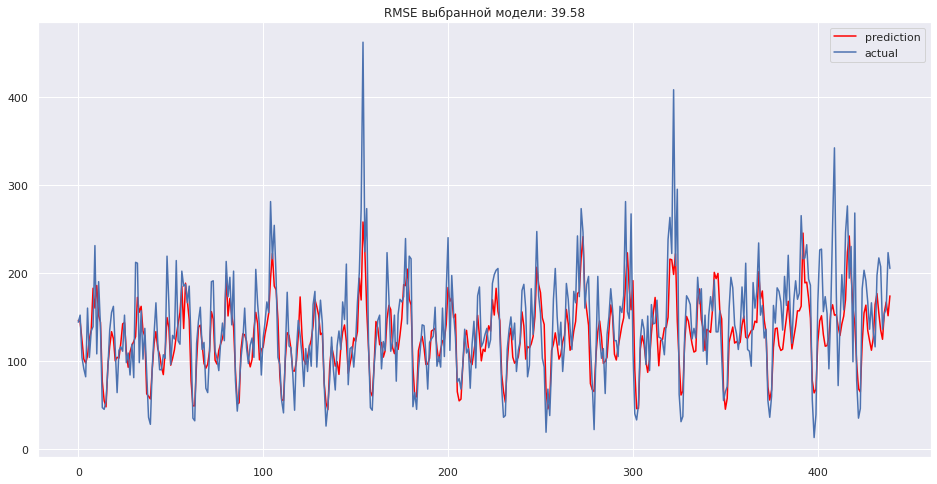

In [93]:
plt.figure(figsize=(16, 8))
plt.plot(final_predictions, 'r', label='prediction')
plt.plot(y_test.values, label='actual')
plt.legend(loc='best')
plt.title(f'RMSE выбранной модели: {final_rmse:.2f}')
plt.grid(True);

Видим, что модель плохо справилась с пиками заказов, однако в остальном отработала достаточно неплохо. 

## Общий вывод

Лучшей моделью для предсказания числа заказов такси стала ансамблевая модель из трех других c подобранными гиперпараметрами и установленными весами для данных моделей (0.6 - для бустинга, по 0.2 - для регрессии и случайного леса).

Потенциальным путем улучшения работы модели может быть добавление взвешенных по времени признаков (например, взвешенной скользящей средней), а также дополнительное исследование аномальных пиков заказов и создания признаков на их основе для более точного предсказания аномального спроса.